### Dam Power Forecasting using Ensemble ML Models

This notebook forecasts scheduled power generation using time-series data.  
It applies XGBoost, LightGBM, and CatBoost in a weighted ensemble.



In [26]:
# 📘 Imports
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import root_mean_squared_error




## 1. Load and Inspect Data
We load the processed power generation data 


In [6]:
# Load data
df = pd.read_csv("../data/processed/scheduled_generation.csv", parse_dates=['Datetime'])

# Clean columns
df.rename(columns={'Scheduled_Generation_MW': 'power'}, inplace=True)
df.sort_values('Datetime', inplace=True)
df.reset_index(drop=True, inplace=True)


In [7]:
df.head()
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128928 entries, 0 to 128927
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   power     128928 non-null  float64       
 1   Datetime  128928 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.0 MB


,power,Datetime
count,128928.000000,128928
mean,352.271602,2022-05-30 12:07:29.999999488
min,0.000000,2020-07-28 00:15:00
25%,90.000000,2021-06-28 18:11:15
50%,300.000000,2022-05-30 12:07:30
75%,683.000000,2023-05-01 06:03:45
max,740.000000,2024-04-01 00:00:00
std,275.050184,NaN


## 2. Feature Engineering
We build lag features, rolling statistics, time-based indicators, and exponential moving averages to enrich the model input.


In [10]:
#  Lag features
for lag in [1, 2, 3, 4, 5, 6]:
    df[f'lag_{lag}'] = df['power'].shift(lag)

#  Rolling stats
for window in [4, 6, 8]:
    df[f'roll_mean_{window}'] = df['power'].shift(1).rolling(window=window).mean()
    df[f'roll_std_{window}'] = df['power'].shift(1).rolling(window=window).std()

#  Differences
df['delta_power_vs_rollmean'] = df['power'] - df['roll_mean_4']
df['lag_diff_1_2'] = df['lag_1'] - df['lag_2']

#  Time-based features
df['hour'] = df['Datetime'].dt.hour
df['month'] = df['Datetime'].dt.month
df['day_of_week'] = df['Datetime'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['day_of_year'] = df['Datetime'].dt.dayofyear
df['season'] = (df['month'] % 12 + 3) // 3

#  Exponential moving average
df['ewm_8'] = df['power'].shift(1).ewm(span=8).mean()

# Final cleanup
df.dropna(inplace=True)


## 3. Data Visualization
We explore trends and relationships between features.



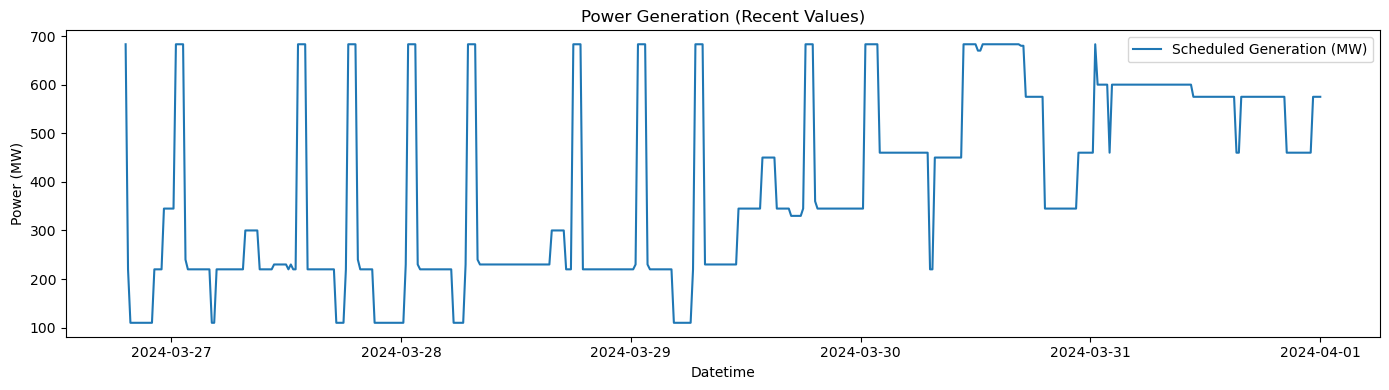

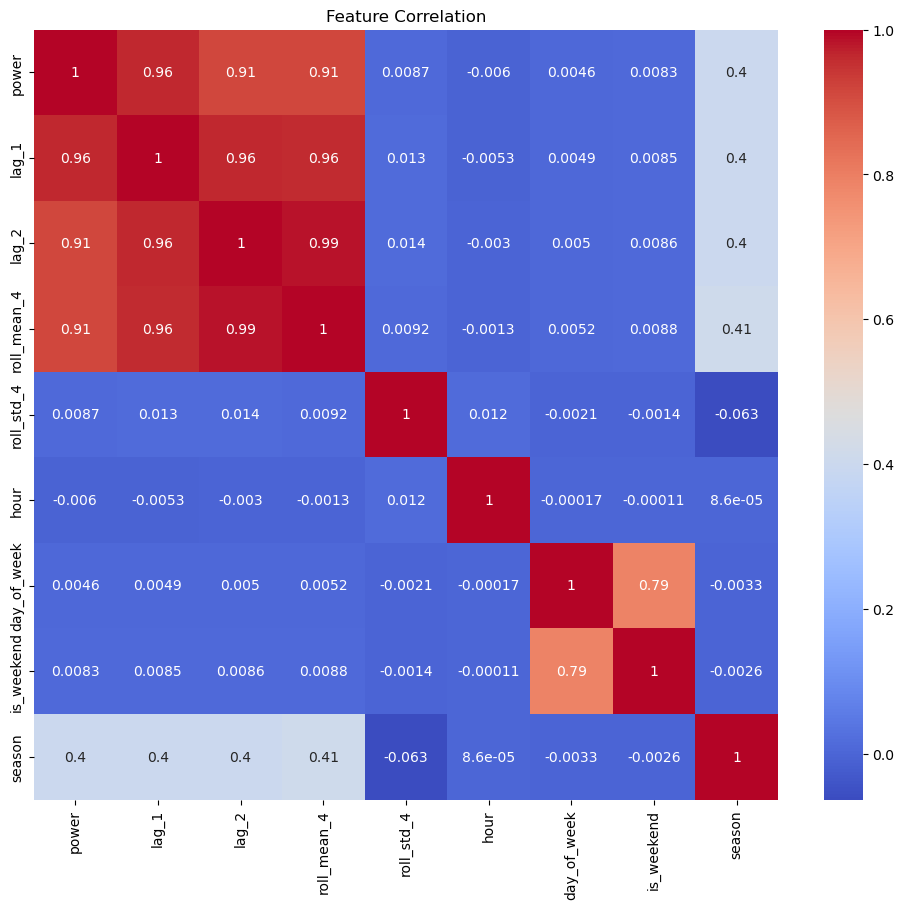

In [11]:
# Plot power trend
plt.figure(figsize=(14, 4))
plt.plot(df['Datetime'][-500:], df['power'][-500:], label='Scheduled Generation (MW)')
plt.title("Power Generation (Recent Values)")
plt.xlabel("Datetime")
plt.ylabel("Power (MW)")
plt.legend()
plt.tight_layout()
plt.show()

#  Feature correlation
plt.figure(figsize=(12, 10))
sns.heatmap(df[[
    'power', 'lag_1', 'lag_2', 'roll_mean_4', 'roll_std_4', 'hour',
    'day_of_week', 'is_weekend', 'season'
]].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()


## 4. Model Training and Prediction
We train three powerful gradient boosting models and blend their predictions for a final ensemble forecast.


In [12]:
# Feature set
features = [
    'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
    'roll_mean_4', 'roll_mean_6', 'roll_mean_8',
    'roll_std_4', 'roll_std_8', 'delta_power_vs_rollmean', 'lag_diff_1_2',
    'hour', 'month', 'day_of_week', 'is_weekend', 'day_of_year', 'season', 'ewm_8'
]

X = df[features]
y = df['power']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)

# ---- Train Models ----

# XGBoost
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.7,
    gamma=0,
    reg_alpha=0.001,
    reg_lambda=2,
    random_state=42
)
xgb_model.fit(X_train, y_train)
pred_xgb = xgb_model.predict(X_test)

# LightGBM
lgb_model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.7,
    reg_alpha=0.001,
    reg_lambda=2,
    random_state=42
)
lgb_model.fit(X_train, y_train)
pred_lgb = lgb_model.predict(X_test)

# CatBoost
cat_model = CatBoostRegressor(
    iterations=300,
    learning_rate=0.03,
    depth=5,
    l2_leaf_reg=2,
    verbose=0,
    random_state=42
)
cat_model.fit(X_train, y_train)
pred_cat = cat_model.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2717
[LightGBM] [Info] Number of data points in the train set: 90238, number of used features: 20
[LightGBM] [Info] Start training from score 351.400028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [40]:
best_accuracy = 0
best_weights_acc = (0.33, 0.33, 0.34)  # Initial

tolerance = 0.10  # ±10%

for w1 in weight_range:
    for w2 in weight_range:
        w3 = 1.0 - w1 - w2
        if w3 < 0 or w3 > 1:
            continue

        y_combined = w1 * pred_xgb + w2 * pred_lgb + w3 * pred_cat
        correct = np.abs(y_combined - y_test.values) <= (tolerance * y_test.values)
        accuracy = correct.sum() / len(correct)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_weights_acc = (w1, w2, w3)

print(f"🎯 Best Accuracy Weights (XGB, LGB, CAT): {best_weights_acc}")



🎯 Best Accuracy Weights (XGB, LGB, CAT): (0.45, 0.30000000000000004, 0.25)


In [41]:
# ---- Weighted Ensemble ----
y_pred = 0.45 * pred_xgb + 0.3 * pred_lgb + 0.25 * pred_cat

## 5. Evaluation
We calculate RMSE, MAE, R², and custom ±10% accuracy. The plot shows prediction quality.


In [42]:
# ---- Metrics ----
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
tolerance = 0.10
correct = np.abs(y_pred - y_test) <= (tolerance * y_test)
accuracy = correct.sum() / len(correct)

print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ MAE: {mae:.2f}")
print(f"✅ R² Score: {r2:.4f}")


# ---- Exclude zero-actuals for ±10% accuracy ----
results_df = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
results_df['Is_Zero_Actual'] = results_df['Actual'] == 0
non_zero_df = results_df[~results_df['Is_Zero_Actual']]

correct_nonzero = np.abs(non_zero_df['Predicted'] - non_zero_df['Actual']) <= (tolerance * non_zero_df['Actual'])
accuracy_excluding_zeros = correct_nonzero.sum() / len(non_zero_df)

print(f"✅ Accuracy (±10% range): {accuracy_excluding_zeros:.2%}")

✅ RMSE: 12.91
✅ MAE: 6.91
✅ R² Score: 0.9980
✅ Accuracy (±10% range): 93.39%


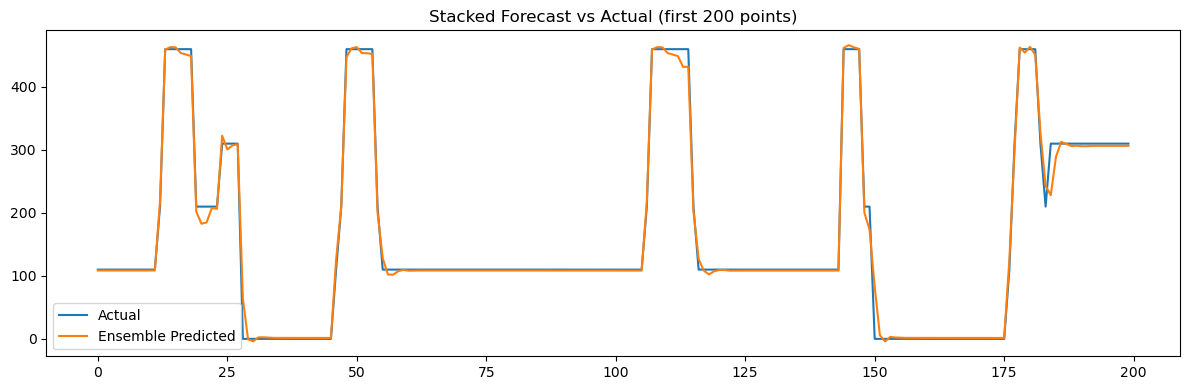

In [43]:
# 🔍 Visualize Prediction vs Actual
plt.figure(figsize=(12, 4))
plt.plot(y_test.values[:200], label='Actual')
plt.plot(y_pred[:200], label='Ensemble Predicted')
plt.legend()
plt.title("Stacked Forecast vs Actual (first 200 points)")
plt.tight_layout()
plt.show()


C:\Users\vishal kumar\AppData\Local\Temp\ipykernel_32800\3248227702.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_avg.index, y=monthly_avg.values, palette='viridis')


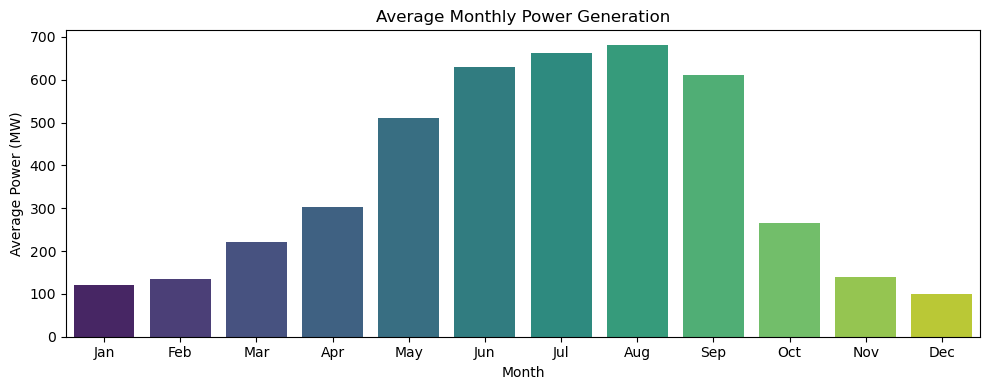

In [44]:
# Monthly average power generation
monthly_avg = df.groupby(df['Datetime'].dt.month)['power'].mean()

plt.figure(figsize=(10, 4))
sns.barplot(x=monthly_avg.index, y=monthly_avg.values, palette='viridis')
plt.title('Average Monthly Power Generation')
plt.xlabel('Month')
plt.ylabel('Average Power (MW)')
plt.xticks(range(12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                       "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.tight_layout()
plt.show()


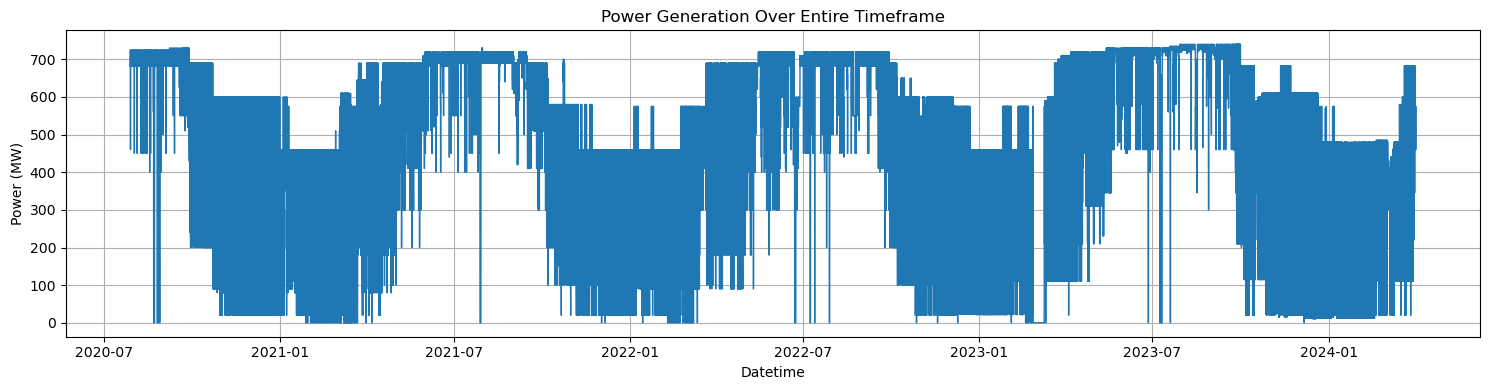

In [20]:
plt.figure(figsize=(15, 4))
plt.plot(df['Datetime'], df['power'], color='tab:blue', linewidth=1)
plt.title('Power Generation Over Entire Timeframe')
plt.xlabel('Datetime')
plt.ylabel('Power (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\vishal kumar\AppData\Local\Temp\ipykernel_32800\2730255855.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month_name', y='power', data=df, order=[


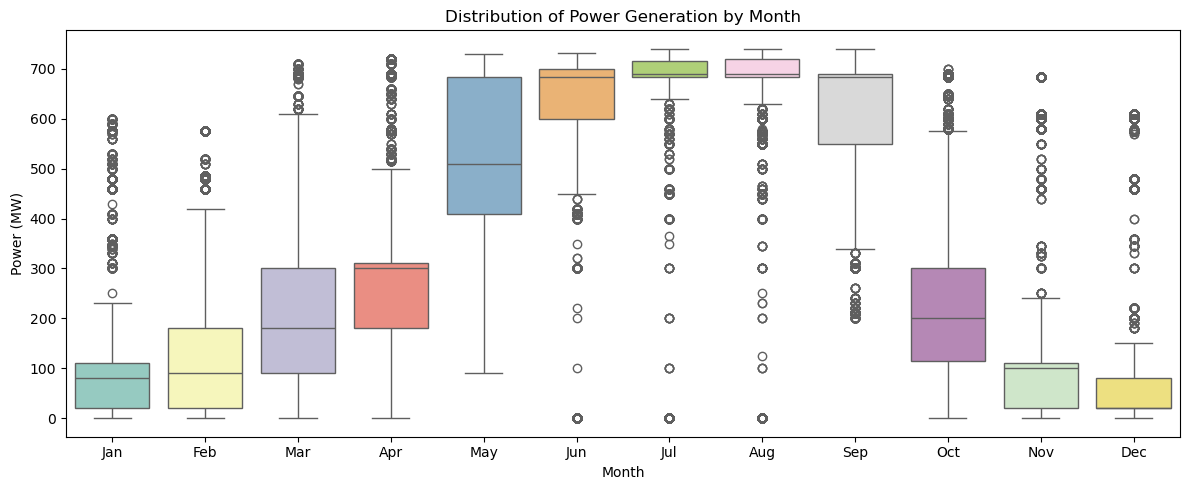

In [21]:
df['month_name'] = df['Datetime'].dt.strftime('%b')
plt.figure(figsize=(12, 5))
sns.boxplot(x='month_name', y='power', data=df, order=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
], palette='Set3')
plt.title('Distribution of Power Generation by Month')
plt.xlabel('Month')
plt.ylabel('Power (MW)')
plt.tight_layout()
plt.show()


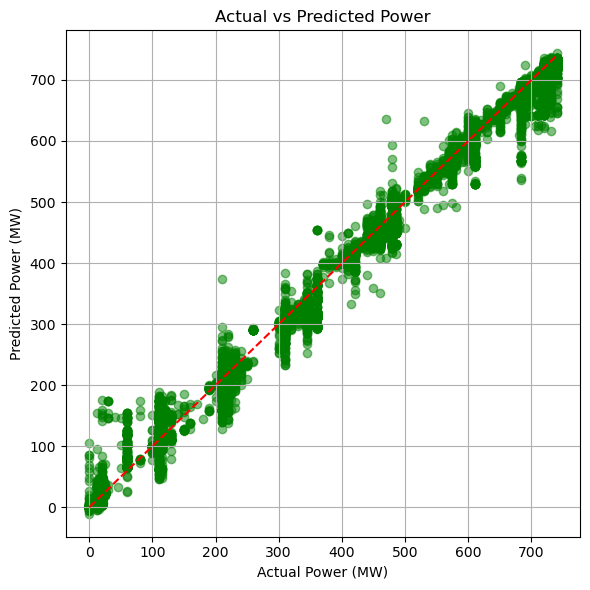

In [23]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Power (MW)')
plt.ylabel('Predicted Power (MW)')
plt.title('Actual vs Predicted Power')
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
from sklearn.metrics import mean_squared_error
import itertools

# Predictions already made
# pred_xgb = xgb_model.predict(X_test)
# pred_lgb = lgb_model.predict(X_test)
# pred_cat = cat_model.predict(X_test)

best_rmse = float("inf")
best_weights = (0.33, 0.33, 0.34)  # default
tolerance = 0.1
grid = [i / 10 for i in range(11)]  # weights from 0.0 to 1.0 in steps of 0.1

# Brute-force grid search for (w1, w2, w3) such that sum == 1.0
for w1, w2, w3 in itertools.product(grid, repeat=3):
    if abs(w1 + w2 + w3 - 1.0) > 1e-6:
        continue  # skip invalid combinations

    y_ensemble = w1 * pred_xgb + w2 * pred_lgb + w3 * pred_cat
    rmse = mean_squared_error(y_test, y_ensemble, squared=False)

    if rmse < best_rmse:
        best_rmse = rmse
        best_weights = (w1, w2, w3)

print(f"✅ Best Weights (XGB, LGB, CAT): {best_weights}")
print(f"✅ Best RMSE: {best_rmse:.4f}")



D:\anaconda1\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
D:\anaconda1\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
D:\anaconda1\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
D:\anaconda1\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.wa

✅ Best Weights (XGB, LGB, CAT): (0.3, 0.3, 0.4)
✅ Best RMSE: 12.7686


D:\anaconda1\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
D:\anaconda1\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
D:\anaconda1\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
D:\anaconda1\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.wa

## 6. Future Forecasting (Next 12 Hours)
We now recursively generate the next 12 hours of scheduled power generation and visualize it.


In [16]:


# Copy the last row as starting input
future_steps = 12
df_future = df.copy()
last_known = df_future.iloc[-1].copy()

future_predictions = []
future_datetimes = []

for i in range(future_steps):
    # Predict next timestamp
    next_datetime = last_known['Datetime'] + pd.Timedelta(hours=1)
    
    # Shift lags
    for lag in range(6, 1, -1):
        last_known[f'lag_{lag}'] = last_known.get(f'lag_{lag-1}', df_future.iloc[-1]['power'])
    last_known['lag_1'] = last_known['power']
    
    # Rolling features
    recent_powers = df_future['power'].iloc[-8:].tolist() + future_predictions
    for w in [4, 6, 8]:
        last_known[f'roll_mean_{w}'] = pd.Series(recent_powers[-w:]).mean()
        last_known[f'roll_std_{w}'] = pd.Series(recent_powers[-w:]).std()
    
    # Other features
    last_known['delta_power_vs_rollmean'] = last_known['lag_1'] - last_known['roll_mean_4']
    last_known['lag_diff_1_2'] = last_known['lag_1'] - last_known['lag_2']
    last_known['hour'] = next_datetime.hour
    last_known['month'] = next_datetime.month
    last_known['day_of_week'] = next_datetime.dayofweek
    last_known['is_weekend'] = int(next_datetime.dayofweek in [5, 6])
    last_known['day_of_year'] = next_datetime.dayofyear
    last_known['season'] = (next_datetime.month % 12 + 3) // 3
    last_known['ewm_8'] = pd.Series(recent_powers[-8:]).ewm(span=8).mean().iloc[-1]

    # Predict using ensemble
    row_input = last_known[features].values.reshape(1, -1)
    pred_x = xgb_model.predict(row_input)[0]
    pred_l = lgb_model.predict(row_input)[0]
    pred_c = cat_model.predict(row_input)[0]
    ensemble_pred = 0.45 * pred_x + 0.5 * pred_l + 0.05 * pred_c

    # Save prediction and datetime
    future_predictions.append(ensemble_pred)
    future_datetimes.append(next_datetime)

    # Update 'last_known' for next iteration
    last_known['Datetime'] = next_datetime
    last_known['power'] = ensemble_pred

# 🔮 Create DataFrame of future forecasts
df_future_forecast = pd.DataFrame({
    'Datetime': future_datetimes,
    'Forecasted_Power': future_predictions
})


C:\Users\vishal kumar\AppData\Local\Temp\ipykernel_32800\4183428284.py:10: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\anaconda1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


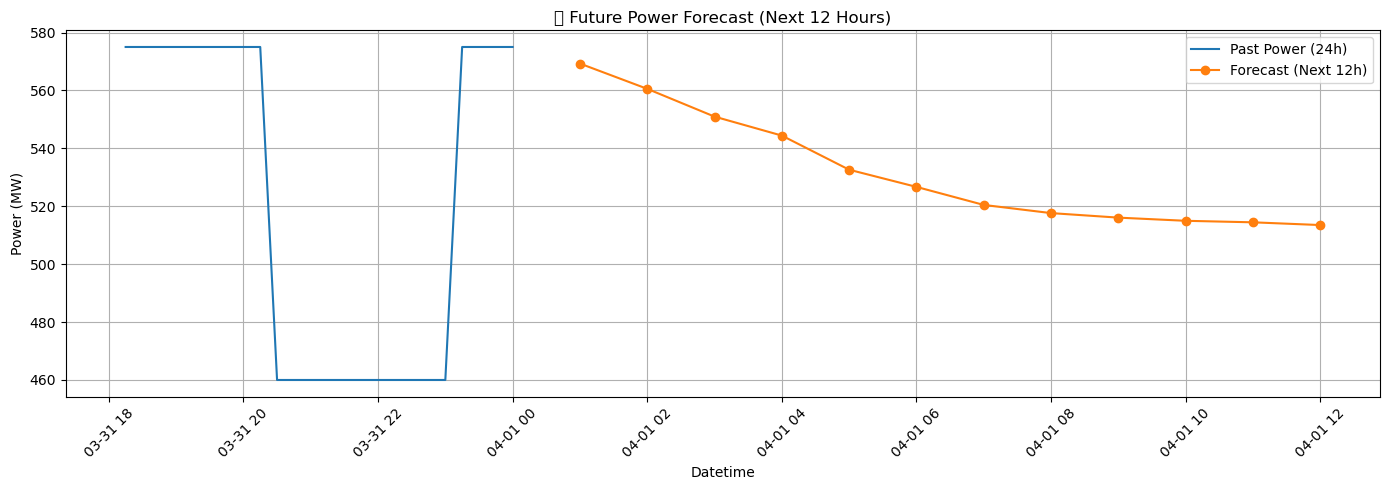

In [45]:
# 📈 Plot last 24 hours + next 12 hours forecast
plt.figure(figsize=(14, 5))
plt.plot(df['Datetime'].iloc[-24:], df['power'].iloc[-24:], label="Past Power (24h)")
plt.plot(df_future_forecast['Datetime'], df_future_forecast['Forecasted_Power'], label="Forecast (Next 12h)", marker='o')
plt.title("📉 Future Power Forecast (Next 12 Hours)")
plt.xlabel("Datetime")
plt.ylabel("Power (MW)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()
